# Gradient-Enhanced PINN (gPINN) Example

### 1. Introduction: Leveraging Derivative Data

This notebook provides a practical, runnable example of a **Gradient-Enhanced Physics-Informed Neural Network (gPINN)**. The core principle is to use not only sparse data of the solution itself ($u(x)$) but also sparse data of its **derivatives** ($\frac{du}{dx}$) to train the model.

This additional gradient information acts as a powerful physical constraint, forcing the network to learn a function that is correct in both its values and its slopes. As we will see, this leads to a significantly more accurate solution compared to a standard PINN that only has access to the solution data.

### 2. Problem Definition
We will solve a simple ODE where we can easily generate both solution and gradient data.
-   **PDE:** $\frac{du}{dx} = \cos(2\pi x)$
-   **Domain:** $x \in [0, 1]$
-   **Initial Condition:** $u(0) = 0$
-   **Analytical Solution:** $u(x) = \frac{\sin(2\pi x)}{2\pi}$
-   **Analytical Derivative:** $\frac{du}{dx} = \cos(2\pi x)$

We will train two models for comparison:
1.  A **gPINN** that uses sparse data for both $u(x)$ and $\frac{du}{dx}$.
2.  A **Standard PINN** that uses only the sparse data for $u(x)$.


In [7]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")


### Step 1: Define PDE and Generate Data

First, we define the geometry, the PDE residual, and the analytical functions for the solution and its derivative.

Next, we generate the sparse "observational" data. We will create two small datasets:
-   `observe_u`: 10 data points for the solution $u(x)$.
-   `observe_grad`: 10 data points for the derivative $\frac{du}{dx}$.



In [8]:
# 1. Define Geometry and PDE
# geom = dde.geometry.Interval(0, 1)
geom = dde.geometry.TimeDomain(0, 1)

def pde(x, u):
    du_dx = dde.grad.jacobian(u, x, i=0, j=0)
    return du_dx - dde.backend.cos(2 * np.pi * x)

# Analytical solution and derivative for generating data
def analytical_solution(x):
    return np.sin(2 * np.pi * x) / (2 * np.pi)

def analytical_derivative(x):
    return np.cos(2 * np.pi * x)

# 2. Generate and Format Observational Data
num_u_data = 10
num_grad_data = 10

observe_x_u = np.linspace(0, 1, num_u_data).reshape(-1, 1)
observe_u = analytical_solution(observe_x_u)

observe_x_grad = np.linspace(0, 1, num_grad_data).reshape(-1, 1)
observe_grad = analytical_derivative(observe_x_grad)


### Step 2: Define Data Constraints

This is the key step in defining a gPINN. We define three types of constraints:
1.  **Initial Condition (IC):** A standard `dde.IC` for $u(0)=0$.
2.  **Solution Data (PointSetBC):** The sparse data for $u(x)$ is incorporated using a standard `dde.PointSetBC`.
3.  **Gradient Data (PointSetOperatorBC):** The sparse data for $\frac{du}{dx}$ is incorporated using a `dde.PointSetOperatorBC`. This special type of boundary condition allows us to apply a constraint to a *derivative* of the network's output, rather than the output itself. We do this by defining a `du_dx_operator` function that computes the derivative and passing it to the `PointSetOperatorBC`.


In [9]:
# 3. Define Data Constraints
ic = dde.IC(geom, lambda x: 0, lambda _, on_initial: on_initial)

# Standard PointSetBC for the solution u(x)
observe_u_bc = dde.PointSetBC(observe_x_u, observe_u, component=0)

# PointSetOperatorBC for the derivative du/dx
def du_dx_operator(x, u, _):
    return dde.grad.jacobian(u, x, i=0, j=0)

observe_grad_bc = dde.PointSetOperatorBC(
    observe_x_grad, observe_grad, du_dx_operator
)


### Step 3: Assemble and Train Models

Now we assemble and train both the gPINN and the standard PINN.

#### 3a. gPINN Model (with Gradient Data)

The gPINN `data` object is created by passing a list containing **all three** constraints: `ic`, `observe_u_bc`, and `observe_grad_bc`.


In [10]:
# --- 4a. Assemble and Train gPINN Model ---
print("--- Training gPINN Model (with gradient data) ---")
data_gpinn = dde.data.PDE(
    geom,
    pde,
    [ic, observe_u_bc, observe_grad_bc],  # Include all constraints
    num_domain=100,
    num_boundary=2,
    solution=analytical_solution,
    num_test=100
)
net_gpinn = dde.nn.FNN([1] + [20] * 3 + [1], "tanh", "Glorot normal")
model_gpinn = dde.Model(data_gpinn, net_gpinn)
model_gpinn.compile("adam", lr=1e-3, metrics=["l2 relative error"])
model_gpinn.train(iterations=15000)


--- Training gPINN Model (with gradient data) ---
Compiling model...
'compile' took 0.000141 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [5.28e-01, 0.00e+00, 1.29e-02, 5.97e-01]    [5.11e-01, 0.00e+00, 1.29e-02, 5.97e-01]    [1.01e+00]    
1000      [3.46e-04, 1.16e-06, 1.87e-06, 6.54e-04]    [3.31e-04, 1.16e-06, 1.87e-06, 6.54e-04]    [1.23e-02]    
2000      [1.15e-04, 1.76e-07, 4.64e-07, 1.38e-04]    [1.16e-04, 1.76e-07, 4.64e-07, 1.38e-04]    [5.74e-03]    
3000      [3.15e-05, 4.47e-08, 1.32e-07, 2.33e-05]    [3.13e-05, 4.47e-08, 1.32e-07, 2.33e-05]    [2.75e-03]    
4000      [3.04e-05, 8.22e-07, 3.82e-07, 8.95e-06]    [3.06e-05, 8.22e-07, 3.82e-07, 8.95e-06]    [4.70e-03]    
5000      [2.49e-05, 1.24e-07, 2.03e-07, 6.84e-06]    [2.52e-05, 1.24e-07, 2.03e-07, 6.84e-06]    [3.94e-03]    
6000      [2.24e-05, 5.43e-09, 9.71e-08, 4.27e-06]    [2.26e-05, 5.43e-09, 9.71e-08, 4.27e-06]

(<deepxde.model.LossHistory at 0x2ed884f5d10>,
 <deepxde.model.TrainState at 0x2ed88424fd0>)

#### 3b. Standard PINN Model (for comparison)

The standard PINN `data` object is created using only the `ic` and `observe_u_bc` constraints. It has no knowledge of the gradient data.


In [ ]:
# --- 4b. Assemble and Train Standard PINN Model (for comparison) ---
print("\n--- Training Standard PINN Model (without gradient data) ---")
data_std = dde.data.PDE(
    geom,
    pde,
    [ic, observe_u_bc],  # Only use IC and u(x) data
    num_domain=100,
    num_boundary=2,
    solution=analytical_solution,
    num_test=100
)


net_std = dde.nn.FNN([1] + [20] * 3 + [1], "tanh", "Glorot normal")
model_std = dde.Model(data_std, net_std)
model_std.compile("adam", lr=1e-3, metrics=["l2 relative error"])
model_std.train(iterations=15000)



--- Training Standard PINN Model (without gradient data) ---
Compiling model...
'compile' took 0.000133 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [7.18e-01, 0.00e+00, 1.17e-01]    [7.35e-01, 0.00e+00, 1.17e-01]    [3.06e+00]    
1000      [6.78e-04, 5.59e-08, 1.29e-06]    [5.88e-04, 5.59e-08, 1.29e-06]    [1.20e-02]    
2000      [1.65e-04, 1.07e-08, 2.00e-07]    [1.32e-04, 1.07e-08, 2.00e-07]    [5.25e-03]    
3000      [4.41e-05, 1.64e-09, 3.94e-08]    [3.63e-05, 1.64e-09, 3.94e-08]    [2.28e-03]    
4000      [3.78e-05, 8.34e-06, 4.57e-06]    [3.11e-05, 8.34e-06, 4.57e-06]    [1.92e-02]    
5000      [1.57e-05, 6.71e-10, 1.92e-08]    [1.26e-05, 6.71e-10, 1.92e-08]    [1.39e-03]    
6000      [9.93e-06, 2.88e-09, 1.32e-08]    [7.77e-06, 2.88e-09, 1.32e-08]    [1.12e-03]    
7000      [6.31e-06, 3.24e-09, 9.28e-09]    [4.82e-06, 3.24e-09, 9.28e-09]    [9.20e-04]    
8000      [4.37e-06, 9.02e-08, 5.95e

(<deepxde.model.LossHistory at 0x2ed884f3890>,
 <deepxde.model.TrainState at 0x2ed88552150>)

### Step 4: Visualize and Compare Results

Finally, we predict the solutions from both models on a dense grid of test points. We then plot both predictions against the analytical solution and the sparse data points.

The results will clearly show that the gPINN, which was constrained by the derivative data, learns a much more accurate function that honors the physics (the slope) across the entire domain. The standard PINN, while fitting the sparse data points for $u(x)$, produces a less accurate interpolation between them. This is confirmed by comparing the final L2 relative errors.



L2 relative error (gPINN): 4.3226e-03
L2 relative error (Standard PINN): 2.2735e-02


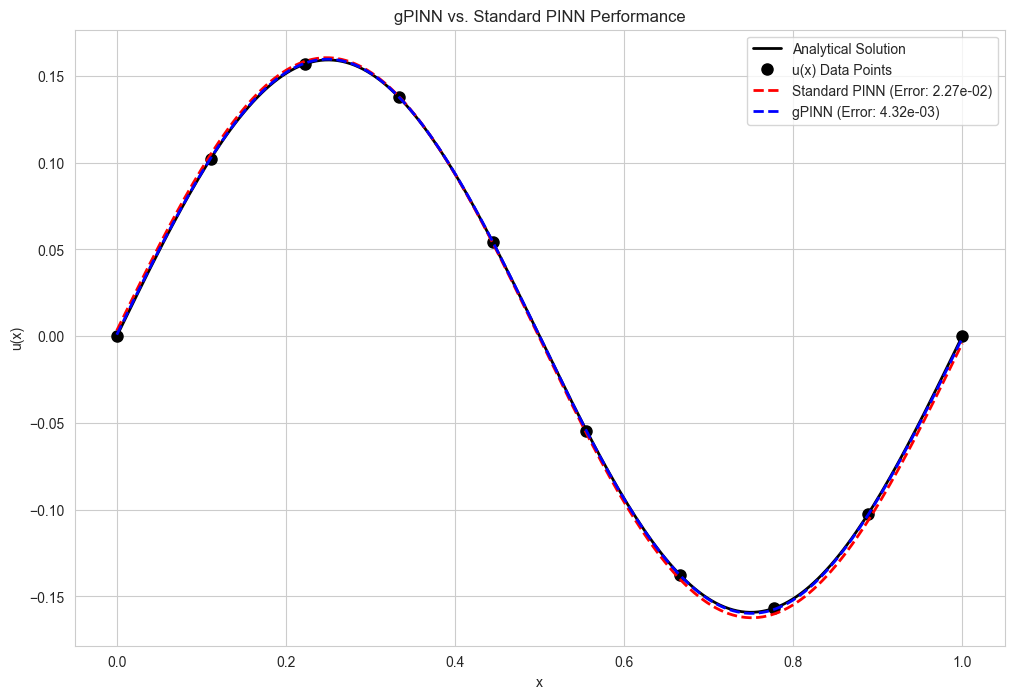

In [12]:
# --- 5. Visualize and Compare ---
x_test = np.linspace(0, 1, 200).reshape(-1, 1)
u_analytical_test = analytical_solution(x_test)
u_gpinn_pred = model_gpinn.predict(x_test)
u_std_pred = model_std.predict(x_test)

l2_error_gpinn = dde.metrics.l2_relative_error(u_analytical_test, u_gpinn_pred)
l2_error_std = dde.metrics.l2_relative_error(u_analytical_test, u_std_pred)

print(f"\nL2 relative error (gPINN): {l2_error_gpinn:.4e}")
print(f"L2 relative error (Standard PINN): {l2_error_std:.4e}")

plt.figure(figsize=(12, 8))
plt.plot(x_test, u_analytical_test, 'k-', label='Analytical Solution', linewidth=2)
plt.plot(observe_x_u, observe_u, 'ko', label='u(x) Data Points', markersize=8)
plt.plot(x_test, u_std_pred, 'r--', label=f'Standard PINN (Error: {l2_error_std:.2e})', linewidth=2)
plt.plot(x_test, u_gpinn_pred, 'b--', label=f'gPINN (Error: {l2_error_gpinn:.2e})', linewidth=2)
plt.title('gPINN vs. Standard PINN Performance')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()
